# ДПО МЛ 4-6 - решения упражнений

## Задача 1: кластеризация запросов и снижение размерности данных

**Данные:** датасет amazon_queries.csv

**Основное задание:**

1.   Выполните предобработку датасета. Подумайте, нужно ли делить данные на тренировочные и тестовые;
2.   Выполните кластеризациюю методом К средних (не применяйте другие методы на этом шаге, если только у вас нет мощного компьютера);
3.   Посмотрите на запросы каждого кластера;
4.   Снизьте размерность данных при помощи любого известного вам метода (подумайте, какой метод здесь будет наиболее подходящим);
5.   Кластеризуйте данные сниженной размерности такой же моделью, как и в шаге 2 (подумайте, что значит "такая же модель");
6.   При помощи метрик, не требующих наличия тестового множества, сравните качество кластеризации на исходных данных и данных сниженной размерности.

**Дополнительно** можете найти оптимальное число кластеров методом локтя (осторожно, вычисления могут занять время).



In [ ]:
# @title
import pandas as pd

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title
from collections import defaultdict

In [ ]:
# @title
query_df = pd.read_csv('/content/drive/MyDrive/ML_training_data/amazon_queries.csv')

In [ ]:
# @title
query_df

,query
0,motorcycle camping tent
1,samson wireless microphone system
2,iphone xs max with ring holder
3,justice league blu ray
4,funny golf shirts for men
...,...
97325,bat skeleton
97326,jigsaw puzzles 500 pieces for adults famous pa...
97327,squidward nike shoes
97328,travis scott posters for room


In [ ]:
# @title
all_queries = list(set(query_df['query'].tolist()))

In [ ]:
# @title
len(all_queries)

97330

In [ ]:
# @title
from sklearn.cluster import KMeans

In [ ]:
# @title
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
# @title
from sklearn.feature_extraction.text import TfidfVectorizer

### 1. Предобработка

В этом датасете нет зависимой переменной, следовательно, деление на тренировочную и тестовую выборку не имеет смысла.

In [ ]:
# @title
vectors = TfidfVectorizer().fit_transform(all_queries)

### 2. Кластеризация

In [ ]:
# @title
k_means_clusters = KMeans(n_clusters=10).fit(vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 3. Посмотрим на тексты каждого кластера:

In [ ]:
# @title
texts_per_cluster = defaultdict(list)

for text, cluster in zip(all_queries, k_means_clusters.labels_):
  texts_per_cluster[cluster].append(text)

In [ ]:
# @title
texts_per_cluster.keys()

dict_keys([8, 1, 6, 5, 4, 7, 9, 2, 3, 0])

In [ ]:
# @title
texts_per_cluster[9][:10]

['iphone max hello kitty case',
 'iphone unlocked cell phones new',
 'iphone 11 case irridescent',
 'iphone 11 case tech 21',
 '10ft iphone charger',
 'portable phone chargers for iphone',
 'portable phone charger iphone',
 'safesleeve iphone x case with card holder',
 'iphone headphones woreless',
 'iphone refurbished']

### Дополнительно: "метод локтя" для определения оптимального количества кластеров:

In [ ]:
# @title
max_cluster = 36
clusters = range(1, max_cluster, 5)
intra_sum_of_square_list = []

for k in clusters:
    km = KMeans(n_clusters=k)
    km.fit(vectors)
    intra_sum_of_square_list.append(km.inertia_)

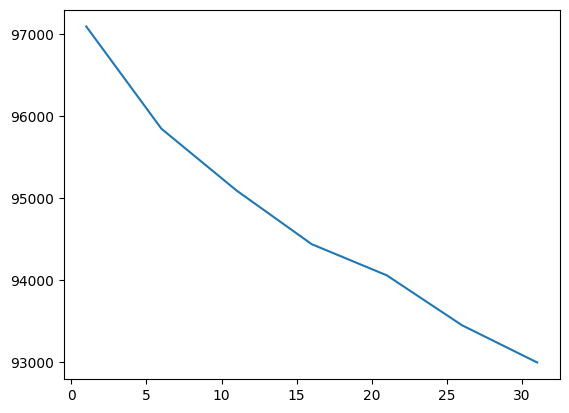

In [ ]:
# @title
plt.plot(clusters, intra_sum_of_square_list)

### 4. Снижение размерности

t-SNE больше подходит для визуализации, а латентное размещение Дирихле - для тематического моделирования, так что для обычного снижения размерности применим сингулярное разложение.

In [ ]:
# @title
from sklearn.decomposition import TruncatedSVD

In [ ]:
# @title
svd = TruncatedSVD(n_components=100)

In [ ]:
# @title
reduced_matrix = svd.fit_transform(vectors)

### 5. Кластеризация на сжатых данных

In [ ]:
# @title
k_means_clusters_reduced = KMeans(n_clusters=10).fit(reduced_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 6. Сравнение результатов

Для оценки кластеризации в условиях отсутствия размеченного тестового множества подойдет коэффициент силуэта.

In [ ]:
# @title
silhouette_kmeans = silhouette_score(vectors, k_means_clusters.labels_)

In [ ]:
# @title
silhouette_kmeans_reduced = silhouette_score(vectors, k_means_clusters_reduced.labels_)

In [ ]:
# @title
silhouette_kmeans

0.006148423640711617

In [ ]:
# @title
silhouette_kmeans_reduced

0.008374200209779085

## Задача 2: тематическое моделирование методом LDA

**Данные:** АРХИВ лемматизированных русских текстов ruslit_lemmas.zip

**Основное задание:**

1.   Достаньте тексты и (на всякий случай) их названия из архива так, как показано в коде;
2.   Векторизуйте тексты. Ограничьте количество используемых признаков до 6000 и используйте стоп-слова;
3.   Сделайте тематическое моделирование при помощи латентного размещения Дирихле. Число компонент выберите любое;
4.   Выведите топовые слова каждой компоненты.



Источник текстов: https://www.kaggle.com/datasets/d0rj3228/russian-literature

### 1. Извлечение информации из архивов:

In [ ]:
from zipfile import ZipFile

path_to_archive = '/content/drive/MyDrive/ML_training_data/ruslit_lemmas.zip'

def texts_from_zip(path_to_archive):
    texts = []
    with ZipFile(path_to_archive) as zip_archive:
        for name in zip_archive.namelist():
            if '.txt' in name:
                text = zip_archive.read(name)
                text = text.decode('utf-8')
                texts.append(text)
    return texts

def get_filenames(path_to_archive):

    names = []

    with ZipFile(path_to_archive) as zip_archive:
        for name in zip_archive.namelist():
            if '.txt' in name:
                names.append(name.split('/')[1])

    return names

### 2. Предобработка

In [ ]:
# @title
names = get_filenames(path_to_archive)

In [ ]:
# @title
#import nltk
#nltk.download('stopwords')

In [ ]:
# @title
from nltk.corpus import stopwords

ru_stop_words = stopwords.words('russian')

In [ ]:
# @title
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# @title
vectorizer = TfidfVectorizer(max_features=6000, stop_words=ru_stop_words)

In [ ]:
# @title
texts = texts_from_zip(path_to_archive)

In [ ]:
# @title
vectors = vectorizer.fit_transform(texts)

### 3. Тематическое моделирование

In [ ]:
# @title
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=50, random_state=0)

In [ ]:
# @title
doc_topic = lda.fit_transform(vectors)

### 4. Самые частотные слова в топиках

In [ ]:
# @title
from collections import defaultdict

In [ ]:
# @title
feature_names = vectorizer.get_feature_names_out()

top_features_per_topic = defaultdict(list)
n_top_words = 30

for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    top_features_per_topic[topic_idx] = top_features

## Задача 3: ансамблевое обучение

**Датасет:** данные о качестве воды BKB_WaterQualityData_2020084.csv.

**Основное задание:**


1.   Выполните предобработку датасета. Ваша зависимая переменная - Site_Id. Ваши независимые переменные: Salinity (ppt), Dissolved Oxygen (mg/L), pH (standard units), Secchi Depth (m), Water Depth (m), Water Temp (?C), AirTemp (C). Подумайте, надо ли что-то кодировать и/или разделять выборку на тренировочное и тестовое множество.
2.   Используйте модели ансамблевого обучения (как минимум, рандомный лес и градиентный бустинг), чтобы по данным о качестве воды предсказать место, откуда был взят образец. Оцените качество предсказаний.


**Дополнительно:** примените GridSearchCV для подбора оптимальных параметров рандомного леса.

**В этом задании можно попробовать:** другие методы ансамблирования, например, обычный бустинг и стекинг.


Данные отсюда: https://www.kaggle.com/datasets/sahirmaharajj/water-quality-data

### 1. Предобработка

In [ ]:
# @title
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
# @title
water_df = pd.read_csv('/content/drive/MyDrive/ML_training_data/BKB_WaterQualityData_2020084.csv')

In [ ]:
# @title
water_df

,Site_Id,Unit_Id,Read_Date,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Depth (m),Water Temp (?C),Air Temp-Celsius,Air Temp (?F),Time (24:00),Field_Tech,DateVerified,WhoVerified,AirTemp (C),Year
0,Bay,NaN,1/3/1994,1.3,11.7,7.3,0.40,0.40,5.9,8.0,46.40,11:00,NaN,NaN,NaN,8.000000,1994
1,Bay,NaN,1/31/1994,1.5,12.0,7.4,0.20,0.35,3.0,2.6,36.68,11:30,NaN,NaN,NaN,2.600000,1994
2,Bay,NaN,2/7/1994,1.0,10.5,7.2,0.25,0.60,5.9,7.6,45.68,9:45,NaN,NaN,NaN,7.600000,1994
3,Bay,NaN,2/23/1994,1.0,10.1,7.4,0.35,0.50,10.0,2.7,36.86,NaN,NaN,NaN,NaN,2.700000,1994
4,Bay,NaN,2/28/1994,1.0,12.6,7.2,0.20,0.40,1.6,0.0,32.00,10:30,NaN,NaN,NaN,0.000000,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,Bay,NaN,10/11/2018,1.9,5.0,7.0,4.00,1.20,25.0,NaN,78.00,09:30,Sue Poe,11/13/2019,Christine Folks,25.555556,2018
2367,Bay,NaN,10/24/2018,0.0,9.0,7.0,0.30,0.60,18.0,NaN,58.00,09:30,Sue Poe,11/13/2019,Christine Folks,14.444444,2018
2368,Bay,NaN,10/28/2018,0.9,2.9,7.0,0.40,0.90,13.0,NaN,49.00,09:20,Sue Poe,11/13/2019,Christine Folks,9.444444,2018
2369,Bay,NaN,11/7/2018,1.7,NaN,7.0,0.45,0.90,20.0,NaN,65.00,09:45,Sue Poe,11/13/2019,Christine Folks,18.333333,2018


In [ ]:
# @title
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371 entries, 0 to 2370
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Site_Id                  2370 non-null   object 
 1   Unit_Id                  32 non-null     object 
 2   Read_Date                2366 non-null   object 
 3   Salinity (ppt)           2241 non-null   float64
 4   Dissolved Oxygen (mg/L)  1520 non-null   float64
 5   pH (standard units)      2276 non-null   float64
 6   Secchi Depth (m)         2298 non-null   float64
 7   Water Depth (m)          2300 non-null   float64
 8   Water Temp (?C)          2250 non-null   float64
 9   Air Temp-Celsius         85 non-null     float64
 10  Air Temp (?F)            2300 non-null   float64
 11  Time (24:00)             2308 non-null   object 
 12  Field_Tech               2332 non-null   object 
 13  DateVerified             453 non-null    object 
 14  WhoVerified             

In [ ]:
# @title
water_df = water_df.drop(columns=['Unit_Id', 'Read_Date', 'Time (24:00)', 'Air Temp (?F)', 'Air Temp-Celsius', 'Year', 'Field_Tech', 'DateVerified', 'WhoVerified'])

In [ ]:
# @title
water_df = water_df.dropna()

In [ ]:
# @title
water_df

,Site_Id,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Depth (m),Water Temp (?C),AirTemp (C)
0,Bay,1.3,11.7,7.3,0.40,0.40,5.9,8.000000
1,Bay,1.5,12.0,7.4,0.20,0.35,3.0,2.600000
2,Bay,1.0,10.5,7.2,0.25,0.60,5.9,7.600000
3,Bay,1.0,10.1,7.4,0.35,0.50,10.0,2.700000
4,Bay,1.0,12.6,7.2,0.20,0.40,1.6,0.000000
...,...,...,...,...,...,...,...,...
2361,D,0.0,6.0,6.5,0.70,1.20,26.0,25.555556
2364,D,0.0,6.9,6.5,0.90,1.30,20.0,18.333333
2366,Bay,1.9,5.0,7.0,4.00,1.20,25.0,25.555556
2367,Bay,0.0,9.0,7.0,0.30,0.60,18.0,14.444444


In [ ]:
# @title
X_water = water_df[[i for i in water_df.columns if i != 'Site_Id']]

In [ ]:
# @title
y_water = water_df['Site_Id'].tolist()

Разделим выборку на тренировочную и тестовую, т.к. мы решаем задачу классификации, качество которой нам позднее нужно будет оценить. Закодируем зависимую переменную, которая сейчас выражена словами и буквами.

In [ ]:
# @title
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# @title
X_water_train, X_water_test, y_water_train, y_water_test = train_test_split(X_water, y_water, test_size=0.2, stratify=y_water)

In [ ]:
# @title
le = LabelEncoder()

In [ ]:
# @title
le.fit(y_water_train)

LabelEncoder()

In [ ]:
# @title
y_water_train_enc = le.transform(y_water_train)
y_water_test_enc = le.transform(y_water_test)

### 2. Ансамблирование

In [ ]:
# @title
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# @title
from sklearn.metrics import classification_report

In [ ]:
# @title
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# @title
water_clf = RandomForestClassifier()

In [ ]:
# @title
water_clf.fit(X_water_train, y_water_train_enc)

RandomForestClassifier()

In [ ]:
# @title
water_clf_preds = water_clf.predict(X_water_test)

In [ ]:
# @title
print(classification_report(y_water_test_enc, water_clf_preds, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.42      0.31      0.36        32
           B       0.62      0.62      0.62        34
         Bay       0.76      0.88      0.82       136
           C       0.64      0.33      0.44        21
           D       0.92      0.88      0.90        41

    accuracy                           0.73       264
   macro avg       0.67      0.60      0.63       264
weighted avg       0.72      0.73      0.72       264



In [ ]:
# @title
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# @title
gbr = GradientBoostingClassifier(random_state=0)

In [ ]:
# @title
gbr.fit(X_water_train, y_water_train_enc)

GradientBoostingClassifier(random_state=0)

In [ ]:
# @title
gbr_preds = gbr.predict(X_water_test)

In [ ]:
# @title
print(classification_report(y_water_test_enc, gbr_preds, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.43      0.28      0.34        32
           B       0.61      0.59      0.60        34
         Bay       0.78      0.88      0.82       136
           C       0.53      0.43      0.47        21
           D       0.90      0.88      0.89        41

    accuracy                           0.73       264
   macro avg       0.65      0.61      0.62       264
weighted avg       0.71      0.73      0.72       264



### Дополнительно: подбор гиперпараметров

In [ ]:
# @title
forest_params = {'max_depth': [2, 5, 10, None], 'max_features': [0.3, 'sqrt', 1.0], 'n_estimators': [10, 100, 500]}

In [ ]:
# @title
gs = GridSearchCV(RandomForestClassifier(), forest_params, scoring='f1_weighted', verbose=1)

In [ ]:
# @title
gs.fit(X_water_train, y_water_train_enc)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 10, None],
                         'max_features': [0.3, 'sqrt', 1.0],
                         'n_estimators': [10, 100, 500]},
             scoring='f1_weighted', verbose=1)

In [ ]:
# @title
gs.best_params_

{'max_depth': 10, 'max_features': 0.3, 'n_estimators': 500}

In [ ]:
# @title
gs_preds = gs.predict(X_water_test)

In [ ]:
# @title
print(classification_report(y_water_test_enc, gs_preds, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.53      0.31      0.39        32
           B       0.61      0.59      0.60        34
         Bay       0.76      0.90      0.83       136
           C       0.60      0.29      0.39        21
           D       0.93      0.90      0.91        41

    accuracy                           0.74       264
   macro avg       0.68      0.60      0.62       264
weighted avg       0.72      0.74      0.72       264

